# 511 Clustering Analysis

### This notebook contains the clustering model and performance testing on the dataset of 511 work zone events. Data and features used in this clustering model can be created by running notebooks 511_00 through 511_04. 

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from pickle import dump


# import dataset
df_511 = pd.read_csv('511_crash_lion_processed_0630.csv')
df_511 = df_511.dropna()
df_511['crash_binary_900ft'] =  df_511['crash_count_900ft'].apply(lambda x: 1 if x>0 else 0)
df_511['crash_binary_1800ft'] = df_511['crash_count_1800ft'].apply(lambda x: 1 if x>0 else 0)
df_511['crash_binary_2700ft'] = df_511['crash_count_2700ft'].apply(lambda x: 1 if x>0 else 0)
df_511['crash_binary_3600ft'] = df_511['crash_count_3600ft'].apply(lambda x: 1 if x>0 else 0)
df_511['create_time'] = pd.to_datetime(df_511['create_time'])
df_511 = df_511.sort_values(by='create_time')
df_511_target = df_511[['event_id',
                        'season',
                        'roadway_type',
                        'create_time_weekend',
                        'street_width',
                        'posted_speed',
                        'daylight_ratio',
                        'peak_ratio',
                        'crash_binary_900ft',
                        'crash_binary_1800ft',
                        'crash_binary_2700ft',
                        'crash_binary_3600ft',
                        'geometry'
                         ]]

C:\Users\ps336\Anaconda3\envs\Python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def split_train_test_setbaseLineScore(df):
    from sklearn.model_selection import train_test_split
    train, test = train_test_split(df, test_size=0.33, random_state = 10)
    train = train.drop(['geometry'],axis=1)
    test = test.drop(['geometry'],axis=1)
    
    prob_by_rwtype = train[['roadway_type',
                        'crash_binary_900ft',
                        'crash_binary_1800ft',
                        'crash_binary_2700ft',
                        'crash_binary_3600ft']].groupby('roadway_type').mean()
    print(prob_by_rwtype.to_markdown())
    test_df = test.copy()
    test_df['y_pred'] = test_df['roadway_type'].apply(lambda x:prob_by_rwtype.loc[x,'crash_binary_900ft'])
    
    # calculating actual value in test data
    prob_by_rwtype_test = test_df[['roadway_type',
                            'crash_binary_900ft',
                            'crash_binary_1800ft',
                            'crash_binary_2700ft',
                            'crash_binary_3600ft']].groupby('roadway_type').mean()
    test_df['y_actual'] = test_df['roadway_type'].apply(lambda x:prob_by_rwtype_test.loc[x,'crash_binary_900ft'])
    
    # this code is from https://stackoverflow.com/questions/51439892/how-to-find-symmetric-mean-absolute-error-in-python
    # smape: https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
    def smape(A, F):
        return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    
    smape_score = smape(test_df['y_pred'],test_df['y_actual'])
    mae_score = mean_absolute_error(test_df['y_pred'],test_df['y_actual'])
    print('900ft')
    print('SMAPE score: {}'.format(smape(test_df['y_pred'],test_df['y_actual'])))
    print('MAE score: {}'.format(mean_absolute_error(test_df['y_pred'],test_df['y_actual']))) 
    
    return train, test, smape_score, mae_score

In [3]:
def cluster_analysis_measure_performance(train_with_all_features, numerical_features, categorical_features, index):
    
    X_train = train_with_all_features.drop(['crash_binary_900ft',
                      'crash_binary_1800ft',
                      'crash_binary_2700ft',
                      'crash_binary_3600ft'], axis=1)
    y_train = train_with_all_features.loc[:, ['crash_binary_900ft',
                      'crash_binary_1800ft',
                      'crash_binary_2700ft',
                      'crash_binary_3600ft']]
    # only using the train dataset for cluster Analysis
    if index:
        X_train = X_train.set_index(index)
    
    train = X_train[numerical_features + categorical_features]
    
    # normalizing the train dataset
    train_norm = train.copy()
    
    # normalizing Numeric data
    column_names_to_normalize = numerical_features
    x = train_norm[column_names_to_normalize].values
    x_scaled = min_max_scaler.fit_transform(x)
    df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = train_norm.index)
    train_norm[column_names_to_normalize] = df_temp
    
    #creating dummies for Categorical Variable
    train_norm = pd.get_dummies(data=train_norm, columns=categorical_features)
    
    # K-means Clustering functions
    def performKmeansClustering(df):
        X = df.copy()
        range_n_clusters = [2,3,4,5,6,7]
        # algo_name = 'KMeans'
        clustering_algo = ['KMeans']
        for algo_name in clustering_algo:
            plt.figure(figsize=(20,15))
            print("\n")
            for i, n_clusters in enumerate(range_n_clusters):

                ax = plt.subplot(230 + i +1)

                ax.set_xlim([-0.1, 1])
                ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

                if algo_name == 'KMeans':
                    model = KMeans(n_clusters=n_clusters, random_state=10)

                clusterer = model
                cluster_labels = clusterer.fit_predict(X)

                silhouette_avg = silhouette_score(X, cluster_labels)
                print("For " + algo_name + " n_clusters =", n_clusters,
                      "The average silhouette_score is :", silhouette_avg)

                sample_silhouette_values = silhouette_samples(X, cluster_labels)

                y_lower = 10
                for i in range(n_clusters):

                    ith_cluster_silhouette_values = \
                        sample_silhouette_values[cluster_labels == i]

                    ith_cluster_silhouette_values.sort()

                    size_cluster_i = ith_cluster_silhouette_values.shape[0]
                    y_upper = y_lower + size_cluster_i

                    color = cm.nipy_spectral(float(i) / n_clusters)
                    ax.fill_betweenx(np.arange(y_lower, y_upper),
                                      0, ith_cluster_silhouette_values,
                                      facecolor=color, edgecolor=color, alpha=0.7)

                    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                    y_lower = y_upper + 10  

                ax.set_title((algo_name +  " clustering "
                              "with n_clusters = %d" % n_clusters),
                             fontsize=14)
                ax.set_xlabel("The silhouette coefficient values")
                ax.set_ylabel("Cluster label")

                ax.axvline(x=silhouette_avg, color="red", linestyle="--")

                ax.set_yticks([])  # Clear the yaxis labels / ticks
                ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

            plt.show()
            
    performKmeansClustering(train_norm)


In [4]:
def perform_Clustering_Visualization_Performance_Measurement(train_with_all_features, test, numerical_features, categorical_features, index, no_cluster):
    
    X_train = train_with_all_features.drop(['crash_binary_900ft',
                      'crash_binary_1800ft',
                      'crash_binary_2700ft',
                      'crash_binary_3600ft'], axis=1)
    y_train_norm = train_with_all_features.loc[:, ['crash_binary_900ft',
                      'crash_binary_1800ft',
                      'crash_binary_2700ft',
                      'crash_binary_3600ft']]
    
    # only using the train dataset for cluster Analysis
    if index:
        X_train = X_train.set_index(index)
    
    train = X_train[numerical_features + categorical_features]
    
    # normalizing the train dataset
    train_norm = train.copy()
    
    # normalizing Numeric data
    column_names_to_normalize = numerical_features
    x = train_norm[column_names_to_normalize].values
    x_scaled = min_max_scaler.fit_transform(x)
    df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = train_norm.index)
    train_norm[column_names_to_normalize] = df_temp
    
    #creating dummies for Categorical Variable
    train_norm = pd.get_dummies(data=train_norm, columns=categorical_features)
    
    # Trying with Number of Cluster= 6 for best Silhoutte Avg Score and normalized features
    X = train_norm.copy()
    kmodel = KMeans(n_clusters=no_cluster, random_state=10)
    cluster_labels = kmodel.fit_predict(X)
    train_norm['kmeans_cluster'] = cluster_labels
    y_train_norm['cluster'] = cluster_labels
    
    
    
    # Visualizing the Cluster stats
    print("Cluster size and distribution")
    print(train_norm.kmeans_cluster.value_counts().to_markdown())
    
    print("Visualizing the histograms for Numerical features Clusters")
    for i in range(no_cluster):
        # visualzing the clusters for Numerical features
        print("Visualizing Cluster {} Numerical features", i)
#         train_norm[train_norm.kmeans_cluster == i][[numerical_features].hist(figsize=(10,10))
#         plt.show()
    print("Visualizing the categorical features across clusters")
    Df_with_Clustering_Features_categorical = train[categorical_features]                                            
    train_with_categorical = pd.merge(train_norm, Df_with_Clustering_Features_categorical, left_index=True, right_index=True)
    for i in range(len(categorical_features)):
        print("Categorical feature - {} across Clusters".format(categorical_features[i]))
        print(train_with_categorical.groupby(['kmeans_cluster', categorical_features[i]]).size().to_markdown())
        
                                                   
    # Measure Performance
    prob_by_cluster_norm = y_train_norm.groupby('cluster').mean()
    print(prob_by_cluster_norm.to_markdown())
    X_test = test.drop(['crash_binary_900ft',
                      'crash_binary_1800ft',
                      'crash_binary_2700ft',
                      'crash_binary_3600ft'], axis=1)
    X_test_with_crash = test.copy()
    # only using the train dataset for cluster Analysis
    if index:
        X_test = X_test.set_index(index)
    
    X_test = X_test[numerical_features + categorical_features]
    X_test_with_dummies = pd.get_dummies(data=X_test, columns=categorical_features)
                                                   
    column_names_to_normalize_test = numerical_features
    x = X_test_with_dummies[column_names_to_normalize_test].values
    x_scaled = min_max_scaler.transform(x)
    df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize_test, index = X_test_with_dummies.index)
    X_test_with_dummies[column_names_to_normalize_test] = df_temp
    
#     print(list(X_test_with_dummies.columns))
    clusterLabels= kmodel.predict(X_test_with_dummies)
    X_test['cluster'] = clusterLabels
    X_test_with_crash['cluster'] = clusterLabels
    
    X_test['crash_prob_900ft_pred'] = X_test['cluster'].apply(lambda x:prob_by_cluster_norm.loc[x,'crash_binary_900ft'])
    
#     Measure actual probabilities in test data by cluster
    prob_by_cluster_norm_test = X_test_with_crash.groupby('cluster').mean()
    X_test_with_crash['crash_prob_900ft_actual'] = X_test_with_crash['cluster'].apply(lambda x:prob_by_cluster_norm_test.loc[x,'crash_binary_900ft'])
                                                   
    # this code is from https://stackoverflow.com/questions/51439892/how-to-find-symmetric-mean-absolute-error-in-python
    # smape: https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
    def smape(A, F):
        return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
                                                   
    smape_score = smape(X_test['crash_prob_900ft_pred'],X_test_with_crash['crash_prob_900ft_actual'])
    mae_score = mean_absolute_error(X_test['crash_prob_900ft_pred'],X_test_with_crash['crash_prob_900ft_actual'])                                               
    print('900 ft')
    print('SMAPE score: {}'.format(smape(X_test['crash_prob_900ft_pred'],X_test_with_crash['crash_prob_900ft_actual'])))
    print('MAE score: {}'.format(mean_absolute_error(X_test['crash_prob_900ft_pred'],X_test_with_crash['crash_prob_900ft_actual'])))
    
    dump(kmodel, open('model.pkl', 'wb'))
    # save the scaler
    dump(min_max_scaler, open('scaler.pkl', 'wb'))
    return train_norm, X_test_with_crash, X_test, smape_score, mae_score



In [5]:
# Assuming Input having atleast following features
# [   'event_id',
#     'season',
#     'roadway_type',
#     'create_time_weekend',
#     'street_width',
#     'posted_speed',
#     'daylight_ratio',
#     'peak_ratio',
#     'crash_binary_900ft',
#     'crash_binary_1800ft',
#     'crash_binary_2700ft',
#     'crash_binary_3600ft',
#     'geometry'
#      ]

In [6]:
# Call function 1 to split train test and set base line score
train, test, base_smape, base_mae = split_train_test_setbaseLineScore(df_511_target)

|   roadway_type |   crash_binary_900ft |   crash_binary_1800ft |   crash_binary_2700ft |   crash_binary_3600ft |
|---------------:|---------------------:|----------------------:|----------------------:|----------------------:|
|              1 |             0.131448 |              0.274265 |              0.395729 |              0.492235 |
|              2 |             0.156173 |              0.269846 |              0.391874 |              0.494309 |
|              3 |             0.142038 |              0.264331 |              0.398726 |              0.540127 |
|              4 |             0.235    |              0.4375   |              0.585    |              0.7175   |
|              9 |             0.12179  |              0.24358  |              0.347762 |              0.448276 |
900ft
SMAPE score: 6.4442846777800336
MAE score: 0.008550689218748188




For KMeans n_clusters = 2 The average silhouette_score is : 0.22859621256168733
For KMeans n_clusters = 3 The average silhouette_score is : 0.24281869667690376
For KMeans n_clusters = 4 The average silhouette_score is : 0.2824848284661057
For KMeans n_clusters = 5 The average silhouette_score is : 0.29314365569991446
For KMeans n_clusters = 6 The average silhouette_score is : 0.3377512726649937
For KMeans n_clusters = 7 The average silhouette_score is : 0.366361782821961


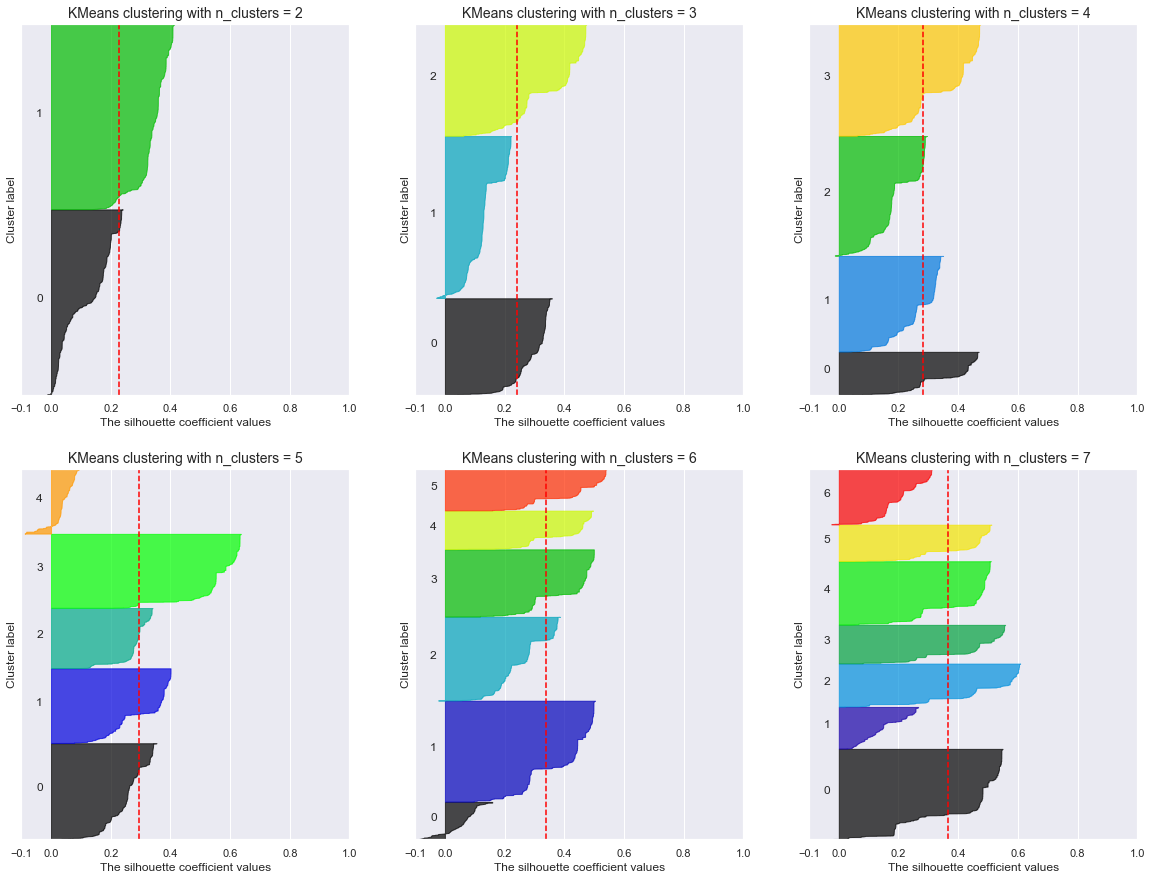

In [7]:
# Call function 2 for Cluster Analysis
numerical_features = ['posted_speed', 'street_width', 'daylight_ratio', 'peak_ratio' ]
categorical_features = ['season', 'roadway_type', 'create_time_weekend']
index = 'event_id'
cluster_analysis_measure_performance(train, numerical_features, categorical_features, index)

In [8]:
# Call Function 3 to implement K-Means on train and measure performance on test
no_cluster=4
print("--------------------------------------------------------------------------------------------------------------------")
print("Performance when number of cluster are {}".format(no_cluster))
train_with_clusterlabels, test_with_clusterlabels, test_with_pred, final_smape, final_mae = perform_Clustering_Visualization_Performance_Measurement(train, test, numerical_features, categorical_features, index, no_cluster)

--------------------------------------------------------------------------------------------------------------------
Performance when number of cluster are 4
Cluster size and distribution
|    |   kmeans_cluster |
|---:|-----------------:|
|  2 |             4498 |
|  3 |             4192 |
|  1 |             3594 |
|  0 |             1596 |
Visualizing the histograms for Numerical features Clusters
Visualizing Cluster {} Numerical features 0
Visualizing Cluster {} Numerical features 1
Visualizing Cluster {} Numerical features 2
Visualizing Cluster {} Numerical features 3
Visualizing the categorical features across clusters
Categorical feature - season across Clusters
|               |    0 |
|:--------------|-----:|
| (0, 'fall')   | 1596 |
| (1, 'fall')   |  447 |
| (1, 'spring') |  627 |
| (1, 'summer') | 1527 |
| (1, 'winter') |  993 |
| (2, 'spring') | 1692 |
| (2, 'winter') | 2806 |
| (3, 'summer') | 4192 |
Categorical feature - roadway_type across Clusters
|        |    0 |
|:--

#### Workzone with Cluster Labels

In [9]:
train_with_clusterlabels.head()

,posted_speed,street_width,daylight_ratio,peak_ratio,season_fall,season_spring,season_summer,season_winter,roadway_type_1,roadway_type_2,roadway_type_3,roadway_type_4,roadway_type_9,create_time_weekend_0,create_time_weekend_1,kmeans_cluster
event_id,,,,,,,,,,,,,,,,
14593,0.166667,0.12,1.0,0.0,0,0,1,0,1,0,0,0,0,1,0,1
21174,0.166667,0.40,0.0,0.0,0,0,1,0,1,0,0,0,0,1,0,1
24497,0.833333,0.24,0.0,0.0,0,1,0,0,0,1,0,0,0,1,0,2
4086,0.833333,0.30,1.0,0.0,0,0,1,0,0,0,1,0,0,1,0,3
5014,0.166667,0.16,0.0,0.0,0,1,0,0,0,0,0,1,0,1,0,2


In [10]:
train_data_with_labels = train_with_clusterlabels[['kmeans_cluster']]

In [11]:
train_data_with_labels.head()

,kmeans_cluster
event_id,
14593,1
21174,1
24497,2
4086,3
5014,2


In [12]:
train_data_with_labels = train_data_with_labels.rename({'kmeans_cluster': 'cluster'}, axis=1)

In [13]:
train_data_with_labels.head()

,cluster
event_id,
14593,1
21174,1
24497,2
4086,3
5014,2


In [14]:
test_data_with_labels = test_with_clusterlabels[['event_id','cluster']]

In [15]:
test_data_with_labels = test_data_with_labels.set_index('event_id')

In [16]:
test_data_with_labels.head()

,cluster
event_id,
9305,2
1549,2
13190,3
14352,1
7183,1


In [17]:
data_with_labels = pd.concat([train_data_with_labels, test_data_with_labels])

In [18]:
data_with_labels.head()

,cluster
event_id,
14593,1
21174,1
24497,2
4086,3
5014,2


In [19]:
data_with_labels.shape

(20717, 1)

In [20]:
import geopandas as gp
df_511_target_geo = gp.GeoDataFrame(df_511_target)

In [21]:
df_511_target_geo = df_511_target_geo.set_index('event_id')

In [22]:
df_511_target_geo['long'] = df_511_target_geo.geometry.apply(lambda x: float(x.split(" ")[1].split("(")[1]))

In [23]:
df_511_target_geo['lat'] = df_511_target_geo.geometry.apply(lambda x: float(x.split(" ")[2].split(")")[0]))

In [24]:
df_511_target_geo.head()

,season,roadway_type,create_time_weekend,street_width,posted_speed,daylight_ratio,peak_ratio,crash_binary_900ft,crash_binary_1800ft,crash_binary_2700ft,crash_binary_3600ft,geometry,long,lat
event_id,,,,,,,,,,,,,,
9800,winter,1,0,70.0,25.0,0.278557,0.138277,0,0,1,1,POINT (-73.97039034710647 40.74801398263635),-73.970390,40.748014
9799,winter,1,0,26.0,25.0,0.476232,0.105634,0,1,1,1,POINT (-74.01492756019137 40.70620793305534),-74.014928,40.706208
22809,winter,2,0,60.0,50.0,0.000000,0.000000,1,1,1,1,POINT (-73.86818973240308 40.7701102900994),-73.868190,40.770110
22808,winter,2,0,40.0,45.0,0.099558,0.000000,0,0,0,0,POINT (-73.94394974075671 40.74045499368583),-73.943950,40.740455
9798,winter,1,1,60.0,25.0,0.036101,0.000000,0,0,0,0,POINT (-73.97477111619014 40.7353946906465),-73.974771,40.735395


In [25]:
df_511_target_geo.shape

(20717, 14)

In [26]:
# Adding Cluster Labels to data
df_511_target_geo_cluster = pd.merge(df_511_target_geo, data_with_labels, left_index=True, right_index=True)

In [27]:
df_511_target_geo_cluster.shape

(20717, 15)

In [28]:
df_511_target_geo_cluster.head()

,season,roadway_type,create_time_weekend,street_width,posted_speed,daylight_ratio,peak_ratio,crash_binary_900ft,crash_binary_1800ft,crash_binary_2700ft,crash_binary_3600ft,geometry,long,lat,cluster
event_id,,,,,,,,,,,,,,,
9800,winter,1,0,70.0,25.0,0.278557,0.138277,0,0,1,1,POINT (-73.97039034710647 40.74801398263635),-73.970390,40.748014,1
9799,winter,1,0,26.0,25.0,0.476232,0.105634,0,1,1,1,POINT (-74.01492756019137 40.70620793305534),-74.014928,40.706208,1
22809,winter,2,0,60.0,50.0,0.000000,0.000000,1,1,1,1,POINT (-73.86818973240308 40.7701102900994),-73.868190,40.770110,2
22808,winter,2,0,40.0,45.0,0.099558,0.000000,0,0,0,0,POINT (-73.94394974075671 40.74045499368583),-73.943950,40.740455,2
9798,winter,1,1,60.0,25.0,0.036101,0.000000,0,0,0,0,POINT (-73.97477111619014 40.7353946906465),-73.974771,40.735395,1


## Saving the workzone with cluster and lat/long

In [29]:
df_511_cluster_geom = df_511_target_geo_cluster[['lat', 'long', 'cluster']]

In [30]:
df_511_cluster_geom.to_csv('511_06_workzone_with_clusterLabels.csv')

In [31]:
df_511_cluster_geom.shape

(20717, 3)

## Cluster Characteristics

##### Workzone distribution across cluster

In [32]:
df_511_target_geo_cluster.cluster.value_counts()

2    6674
3    6275
1    5387
0    2381
Name: cluster, dtype: int64

##### Visualizing Numerical feature distribution for clusters

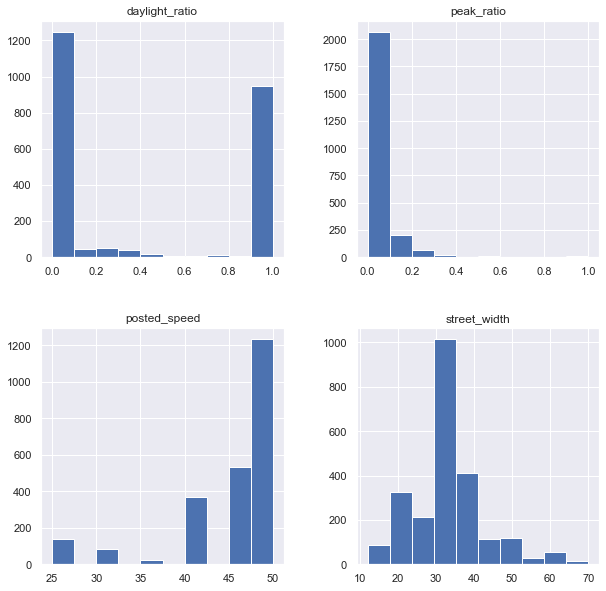

In [33]:
# # visualzing the clusters for Numerical features
df_511_target_geo_cluster[df_511_target_geo_cluster.cluster == 0][['posted_speed', 'street_width', 'daylight_ratio', 'peak_ratio' ]].hist(figsize=(10,10))
plt.show()

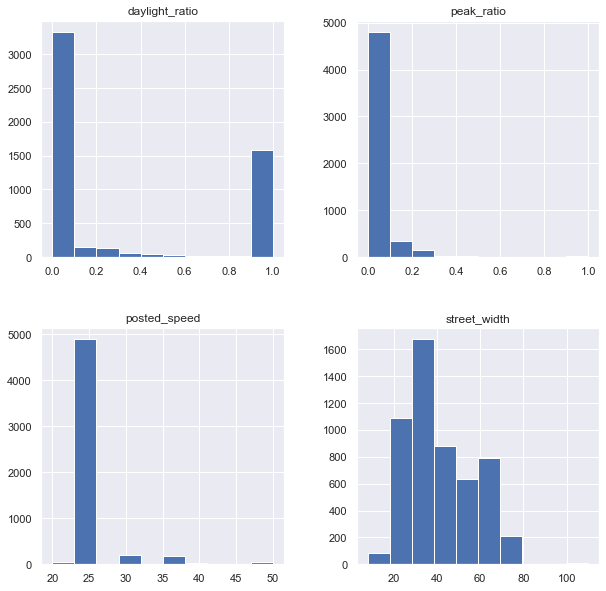

In [34]:
# # visualzing the clusters for Numerical features
df_511_target_geo_cluster[df_511_target_geo_cluster.cluster == 1][['posted_speed', 'street_width', 'daylight_ratio', 'peak_ratio' ]].hist(figsize=(10,10))
plt.show()

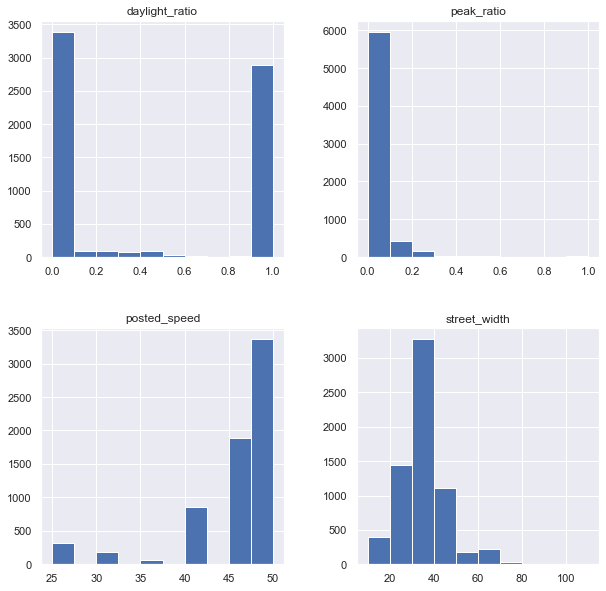

In [35]:
# # visualzing the clusters for Numerical features
df_511_target_geo_cluster[df_511_target_geo_cluster.cluster == 2][['posted_speed', 'street_width', 'daylight_ratio', 'peak_ratio' ]].hist(figsize=(10,10))
plt.show()

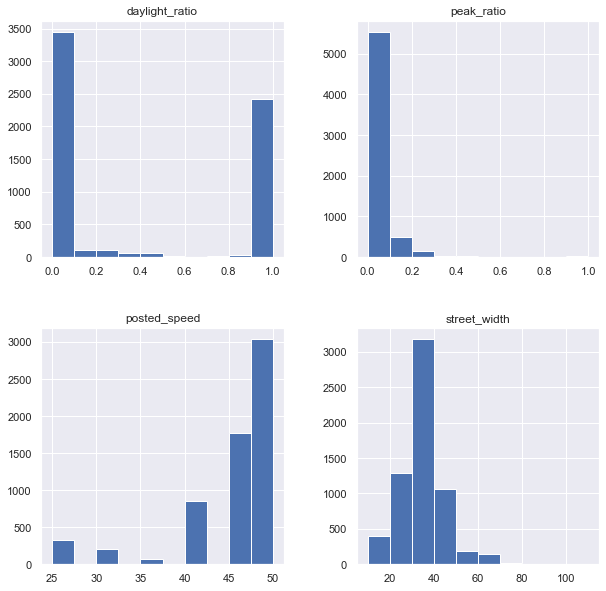

In [36]:
# # visualzing the clusters for Numerical features
df_511_target_geo_cluster[df_511_target_geo_cluster.cluster == 3][['posted_speed', 'street_width', 'daylight_ratio', 'peak_ratio' ]].hist(figsize=(10,10))
plt.show()

##### Feature mean across each Cluster

In [37]:
Features_Mean_by_cluster = df_511_target_geo_cluster[['posted_speed', 'street_width', 'daylight_ratio', 'peak_ratio', 'cluster' ]].groupby('cluster').mean()
Features_Mean_by_cluster

,posted_speed,street_width,daylight_ratio,peak_ratio
cluster,,,,
0,45.236035,33.199916,0.426877,0.031557
1,25.779655,39.530536,0.325529,0.029283
2,45.680701,33.314354,0.454791,0.029223
3,45.313625,33.059442,0.409725,0.030654


##### Visualizing categorical features distribution across clusters

In [38]:
df_511_target_geo_cluster.groupby(['cluster', 'season']).size()

cluster  season
0        fall      2381
1        fall       693
         spring     920
         summer    2238
         winter    1536
2        spring    2482
         winter    4192
3        summer    6275
dtype: int64

In [39]:
df_511_target_geo_cluster.groupby(['cluster', 'roadway_type']).size()

cluster  roadway_type
0        1                 14
         2               1628
         3                336
         4                 93
         9                310
1        1               5387
2        2               4563
         3                940
         4                253
         9                918
3        2               4178
         3               1040
         4                243
         9                814
dtype: int64

In [40]:
df_511_target_geo_cluster.groupby(['cluster', 'create_time_weekend']).size()

cluster  create_time_weekend
0        0                      2156
         1                       225
1        0                      4748
         1                       639
2        0                      6053
         1                       621
3        0                      5684
         1                       591
dtype: int64

#### Cluster Definition when k=4 and Normalized Features

                                Cluster 0:                                          Cluster 1:                                Cluster 2:                                       Cluster 3:                                            
    daylight_ratio:    More Jobs in evening and night                          More weights to night WZ                    similar weights to both day/ night WZ            similar weights to both day/ night WZ            
    peak_ratio:        Good weight to peak_time                                lesser wt to peak_time                      little weight to peak_time                       more weight to peak_time    
    posted_speed:      more weight speed = 50                                  more wt to lesser speed(25)                 more wt to higher speed                          more wt to higher speed     
    street_width:      more wieght to avg & lesser st width(40)                more wt to higher st width(40, 60)          more wt to lesser st width                       more wt to lesser st width  
    
    season:            mostly fall                                             mostly summer & winter                      mostly winter                                    summer                      
    roadway_type:      2                                                       1                                           2                                                2                           
    Weekend:           not important feature, mostly
                       weekday for all clusters
    

#### Comparing Scores of Predicted and Actual Crash probability

In [45]:
test_with_clusterlabels.head()

,event_id,season,roadway_type,create_time_weekend,street_width,posted_speed,daylight_ratio,peak_ratio,crash_binary_900ft,crash_binary_1800ft,crash_binary_2700ft,crash_binary_3600ft,cluster,crash_prob_900ft_actual
7293,9305,winter,2,0,34.0,50.0,1.0,0.0,1,1,1,1,2,0.142004
1193,1549,winter,2,0,20.0,40.0,1.0,0.0,0,0,1,1,2,0.142004
10324,13190,summer,2,0,38.0,50.0,0.0,0.0,0,1,1,1,3,0.149784
11223,14352,summer,1,0,50.0,25.0,0.0,0.0,0,0,0,0,1,0.113776
5561,7183,summer,1,0,20.0,25.0,0.0,0.0,0,0,1,1,1,0.113776


In [48]:
test_with_pred_df = test_with_pred.reset_index()

In [49]:
test_with_pred_df.head(2)

,event_id,posted_speed,street_width,daylight_ratio,peak_ratio,season,roadway_type,create_time_weekend,cluster,crash_prob_900ft_pred
0,9305,50.0,34.0,1.0,0.0,winter,2,0,2,0.138506
1,1549,40.0,20.0,1.0,0.0,winter,2,0,2,0.138506


In [50]:
test_merged_plot = pd.merge(test_with_clusterlabels[['event_id', 'crash_prob_900ft_actual', 'cluster']], test_with_pred_df[['event_id', 'crash_prob_900ft_pred']], on='event_id')

In [51]:
test_merged_plot.head(2)

,event_id,crash_prob_900ft_actual,cluster,crash_prob_900ft_pred
0,9305,0.142004,2,0.138506
1,1549,0.142004,2,0.138506


In [52]:
test_merged_plot.shape

(6837, 4)

In [ ]:
plt.scatter

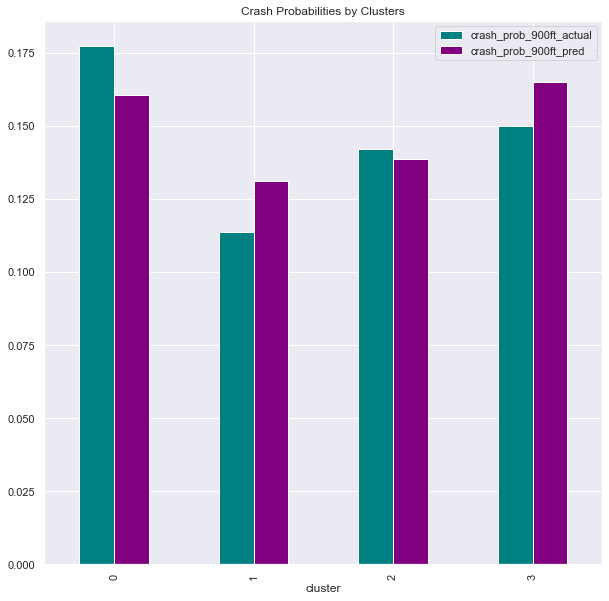

In [64]:
test_merged_plot.groupby('cluster').agg({'crash_prob_900ft_actual':'mean', 'crash_prob_900ft_pred':'mean'}).plot.bar(figsize=(10,10), color=['teal', 'purple'], title="Crash Probabilities by Clusters")

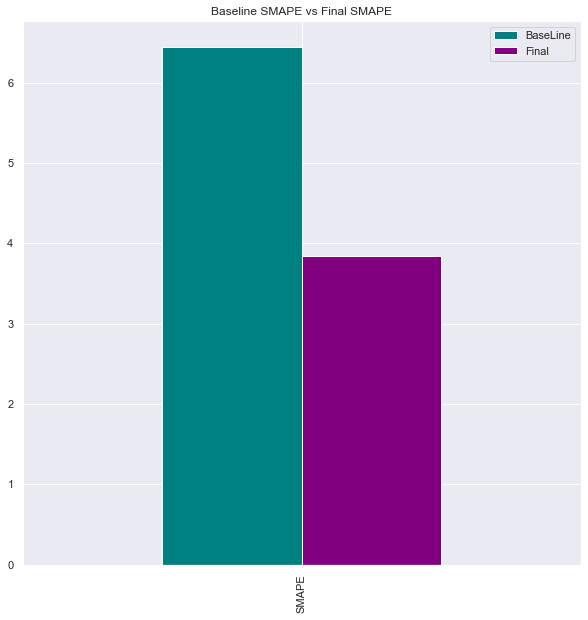

In [65]:
BaseLine = [base_smape ]
Final = [final_smape]
index = ['SMAPE']
df = pd.DataFrame({'BaseLine': BaseLine,
                   'Final': Final}, index=index)
ax = df.plot.bar(figsize=(10,10), color=['teal', 'purple' ], title="Baseline SMAPE vs Final SMAPE")